In [1]:
!apt-get update
!apt-get install -y libavif-dev
!pip install roboflow

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [85.0 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,361 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,745 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [6,477 kB]
Get:13 https://ppa.launchpadcontent.net/deads

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.5 MB/s eta 0:00:00


# MODELO YOLO Normal

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="Re7EXPsDbI2WxmePrafM")
project = rf.workspace("miotistudent").project("bb_cardamage-final")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to BB_CarDamage-Final-1 in yolov11:: 100%|██████████| 9244/9244 [00:01<00:00, 7183.75it/s]


In [4]:
import os

def fix_labels(directory):
    if not os.path.exists(directory):
        print(f"⚠️ Saltando: {directory} (No existe)")
        return

    count = 0
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            path = os.path.join(directory, filename)
            with open(path, 'r') as f:
                lines = f.readlines()

            fixed_lines = []
            for line in lines:
                parts = line.split()
                if len(parts) >= 5:
                    cls = parts[0]
                    # Ajustamos las coordenadas al rango [0, 1]
                    coords = [max(0.0, min(1.0, float(x))) for x in parts[1:]]
                    fixed_line = f"{cls} " + " ".join([f"{c:.6f}" for c in coords]) + "\n"
                    fixed_lines.append(fixed_line)

            with open(path, 'w') as f:
                f.writelines(fixed_lines)
            count += 1
    print(f"✅ Se repararon {count} archivos en: {directory}")

# Intentar con ambos nombres comunes: 'val' y 'valid'
for folder in ['train', 'valid', 'val', 'test']:
    fix_labels(f"{dataset.location}/{folder}/labels")

print("\n🚀 ¡Listo! Ahora corre el código de entrenamiento de YOLO11.")

✅ Se repararon 3349 archivos en: /content/BB_CarDamage-Final-1/train/labels
✅ Se repararon 838 archivos en: /content/BB_CarDamage-Final-1/valid/labels
⚠️ Saltando: /content/BB_CarDamage-Final-1/val/labels (No existe)
✅ Se repararon 429 archivos en: /content/BB_CarDamage-Final-1/test/labels

🚀 ¡Listo! Ahora corre el código de entrenamiento de YOLO11.


In [5]:
from ultralytics import YOLO
import os

# 1. Definir el modelo (m = medium, balance ideal entre velocidad y precisión)
# También puedes usar 'yolo11n.pt' (nano) o 'yolo11x.pt' (extra large)
model_name = 'yolo11l.pt'

# Limpieza opcional para asegurar una descarga fresca
if os.path.exists(model_name):
    os.remove(model_name)

# 2. Cargar el modelo YOLOv11
model = YOLO(model_name)

# 3. Entrenar el modelo
# Asegúrate de haber exportado tu dataset desde Roboflow como "YOLOv11" o "YOLOv8" (formato estándar)
results = model.train(
    data=f"{dataset.location}/data.yaml",
    epochs=50,      # Puedes subirlo a 100 si tienes tiempo, v11 aprende muy rápido
    imgsz=640,      # Tamaño de imagen estándar
    batch=16,       # Al no ser OBB, puedes intentar subir el batch si la GPU lo permite
    device='0',     # Usa 0 para GPU NVIDIA (Tesla T4 en Colab)
    project='CarDamage_v11', # Nombre de la carpeta de resultados
    name='experimento_estandar'
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/BB_CarDamage-Final-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=6

In [6]:
# 4. Evaluación final con el set de TEST
print("Iniciando evaluación final con imágenes de TEST...")
metrics = model.val(split='test') # Esto le dice a YOLO: "Usa la carpeta test del data.yaml"

# 5. Opcional: Probar el modelo con una imagen real del test para ver los cuadritos
results_pred = model.predict(source=f"{dataset.location}/test/images", save=True, imgsz=640)

Iniciando evaluación final con imágenes de TEST...
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
YOLO11l summary (fused): 191 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 21.9±10.5 MB/s, size: 42.9 KB)
val: Scanning /content/BB_CarDamage-Final-1/test/labels... 429 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 429/429 720.0it/s 0.6s
val: New cache created: /content/BB_CarDamage-Final-1/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.1s
                   all        429        948      0.724        0.7      0.733      0.588
                 crack         70        103       0.59      0.359      0.416      0.231
                  dent        183        260      0.625      0.514       0.57      0.338
         glass shatter         55         55      0.934          1      0.995      0.947
       


image 1/429 /content/BB_CarDamage-Final-1/test/images/000001_jpg.rf.9abbb12e8b3569fe8990b3bb3d09cab0.jpg: 512x640 1 scratch, 1 tire flat, 38.9ms
image 2/429 /content/BB_CarDamage-Final-1/test/images/000021_jpg.rf.9f669b8e805d44abde8e1a8e7fb0eddd.jpg: 512x640 1 scratch, 38.9ms
image 3/429 /content/BB_CarDamage-Final-1/test/images/000024_jpg.rf.7422a881e8f247dc9067ad77ec7a5a3b.jpg: 512x640 1 lamp broken, 1 scratch, 38.9ms
image 4/429 /content/BB_CarDamage-Final-1/test/images/000025_jpg.rf.3b983fa52344ac0f23505522454b4801.jpg: 512x640 1 lamp broken, 1 scratch, 31.8ms
image 5/429 /content/BB_CarDamage-Final-1/test/images/000027_jpg.rf.84461cd03537b4911ee29c604f382f4c.jpg: 512x640 1 scratch, 26.4ms
image 6/429 /content/BB_CarDamage-Final-1/test/images/000041_jpg.rf.ee52487143e68f2ef2fea3d2f4e26ce9.jpg: 512x640 1 glass shatter, 26.4ms
image 7/429 /content/BB_CarDamage-Final-1/test/images/000044_jpg.rf.e84994ba89425a4a9b6c3144d6c7c3d8.jpg: 512x640 3 cracks, 1 dent, 2 scratchs, 26.0ms
image 8

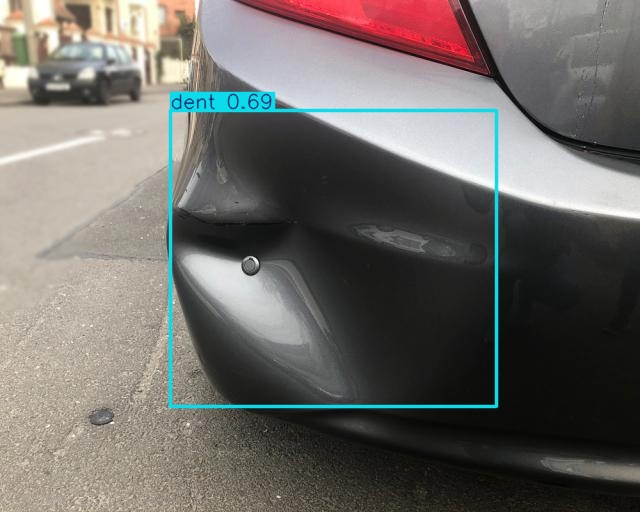

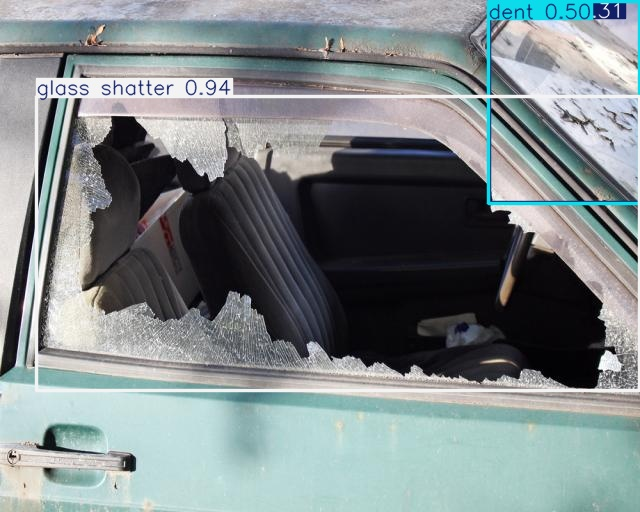

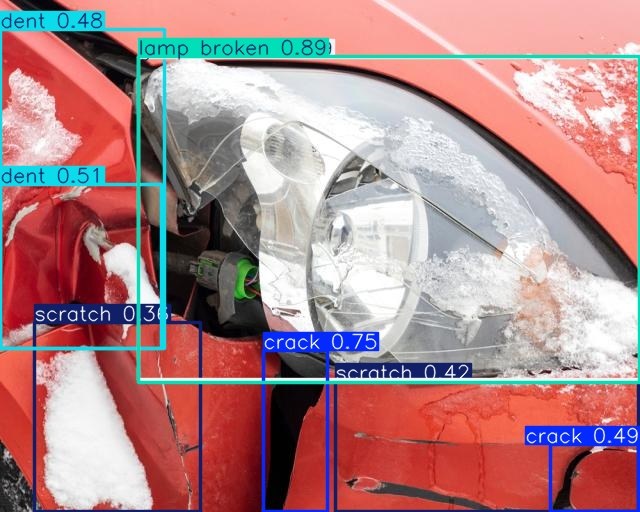

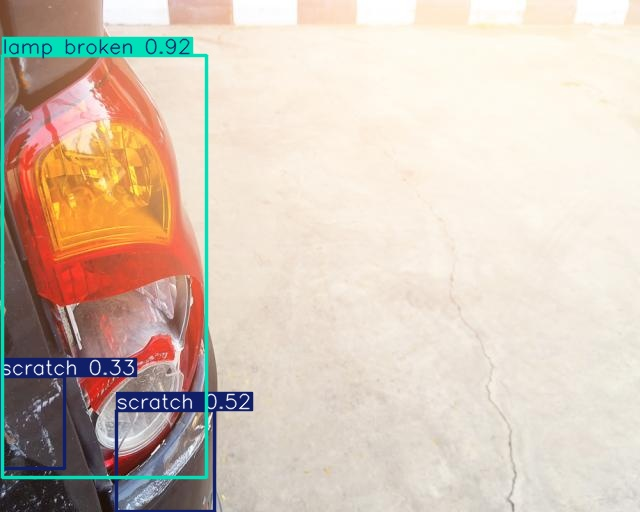

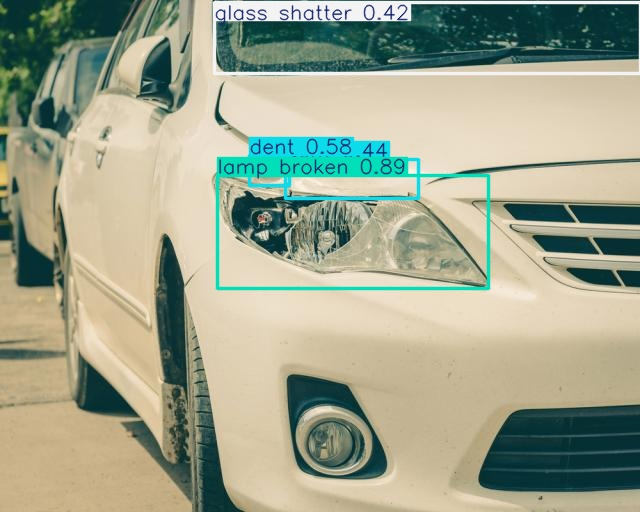

In [8]:
# 1. Ejecutar predicción en el set de test (si no lo hiciste)
model.predict(source=f"{dataset.location}/test/images", save=True, imgsz=640)

# 2. Buscar la carpeta 'predict' más nueva
latest_predict = sorted(glob.glob('runs/detect/predict*/'))[-1]
pred_images = glob.glob(os.path.join(latest_predict, "*.jpg"))

print(f"Mostrando imágenes desde: {latest_predict}")

# 3. Mostrar las primeras 5 imágenes para validar
for img_path in pred_images[:5]:
    display(Image(filename=img_path, width=600))

In [9]:
import shutil
from google.colab import files

# Definimos la carpeta que queremos comprimir
# Si usaste el código anterior, la ruta es 'CarDamage_YOLO11'
folder_path = 'runs/'
zip_file = 'Resultados_YOLO11_1702.zip'

# Creamos el archivo ZIP
shutil.make_archive('Resultados_YOLO11_1702', 'zip', folder_path)

# Descargamos el archivo a tu PC
files.download(zip_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>